In [56]:

import os 
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab\Code\distinguish_pac')
import module_pac_functions as pacf
import matplotlib.gridspec as gridspec


In [30]:
# Set directory in which the data structure can be found
os.chdir(r'C:\Users\jaapv\Desktop\master\VoytekLab')

# data
datastruct = np.load('datastruct_rats.npy',  allow_pickle=True)

# dataframes
features_df = pd.read_csv('features_df_rats.csv', sep=',')
burst_list = np.load('burst_list_rats.npy',  allow_pickle=True)


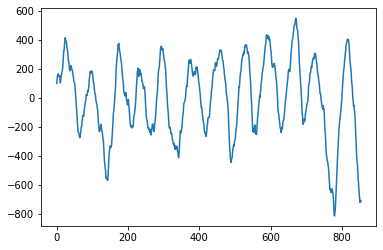

In [31]:
plt.plot(data - np.mean(data))

In [93]:
import pandas as pd
import module_pac_functions as pacf
from scipy.signal import hilbert
import numpy as np
from fooof import FOOOF
from neurodsp import spectral
import scipy as sp



9.840630173042458
2.0000000000000004
The Rho-value of PAC is:      0.3925714258539627
The p-value of PAC is:        0.0


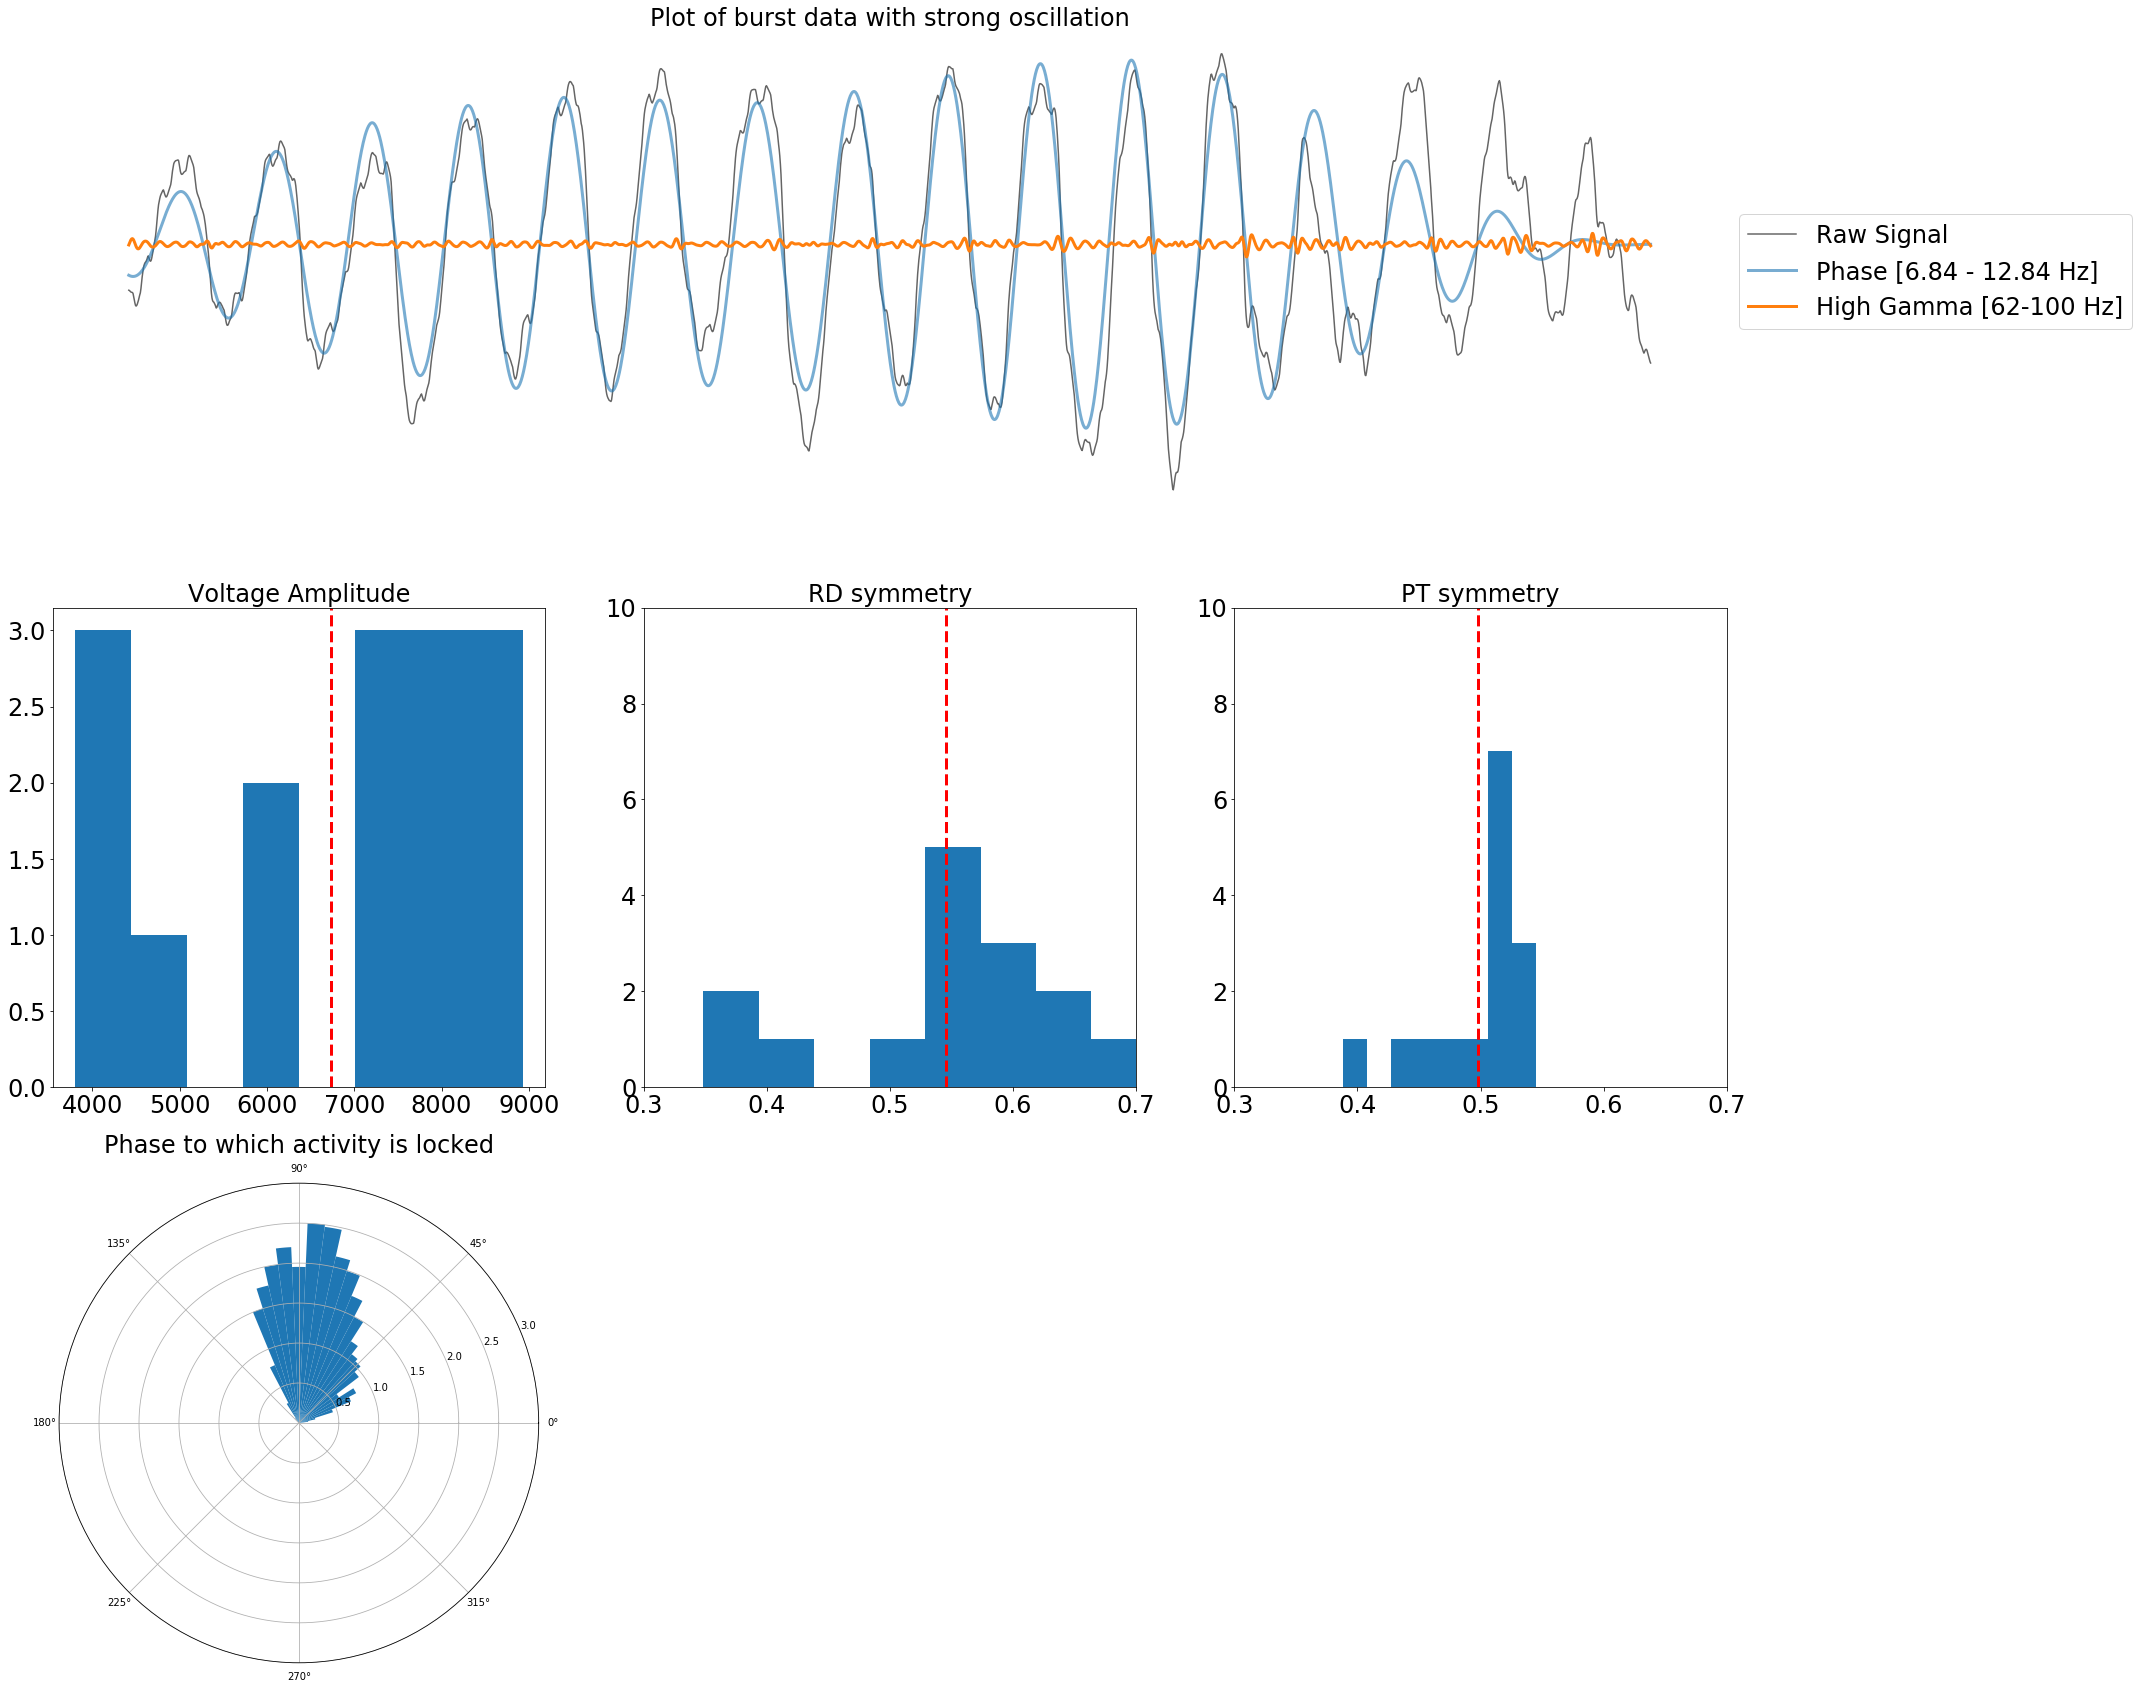

9.90985335138201
2.0000000000000004
The Rho-value of PAC is:      0.15673974236567584
The p-value of PAC is:        1.1102230246251565e-16


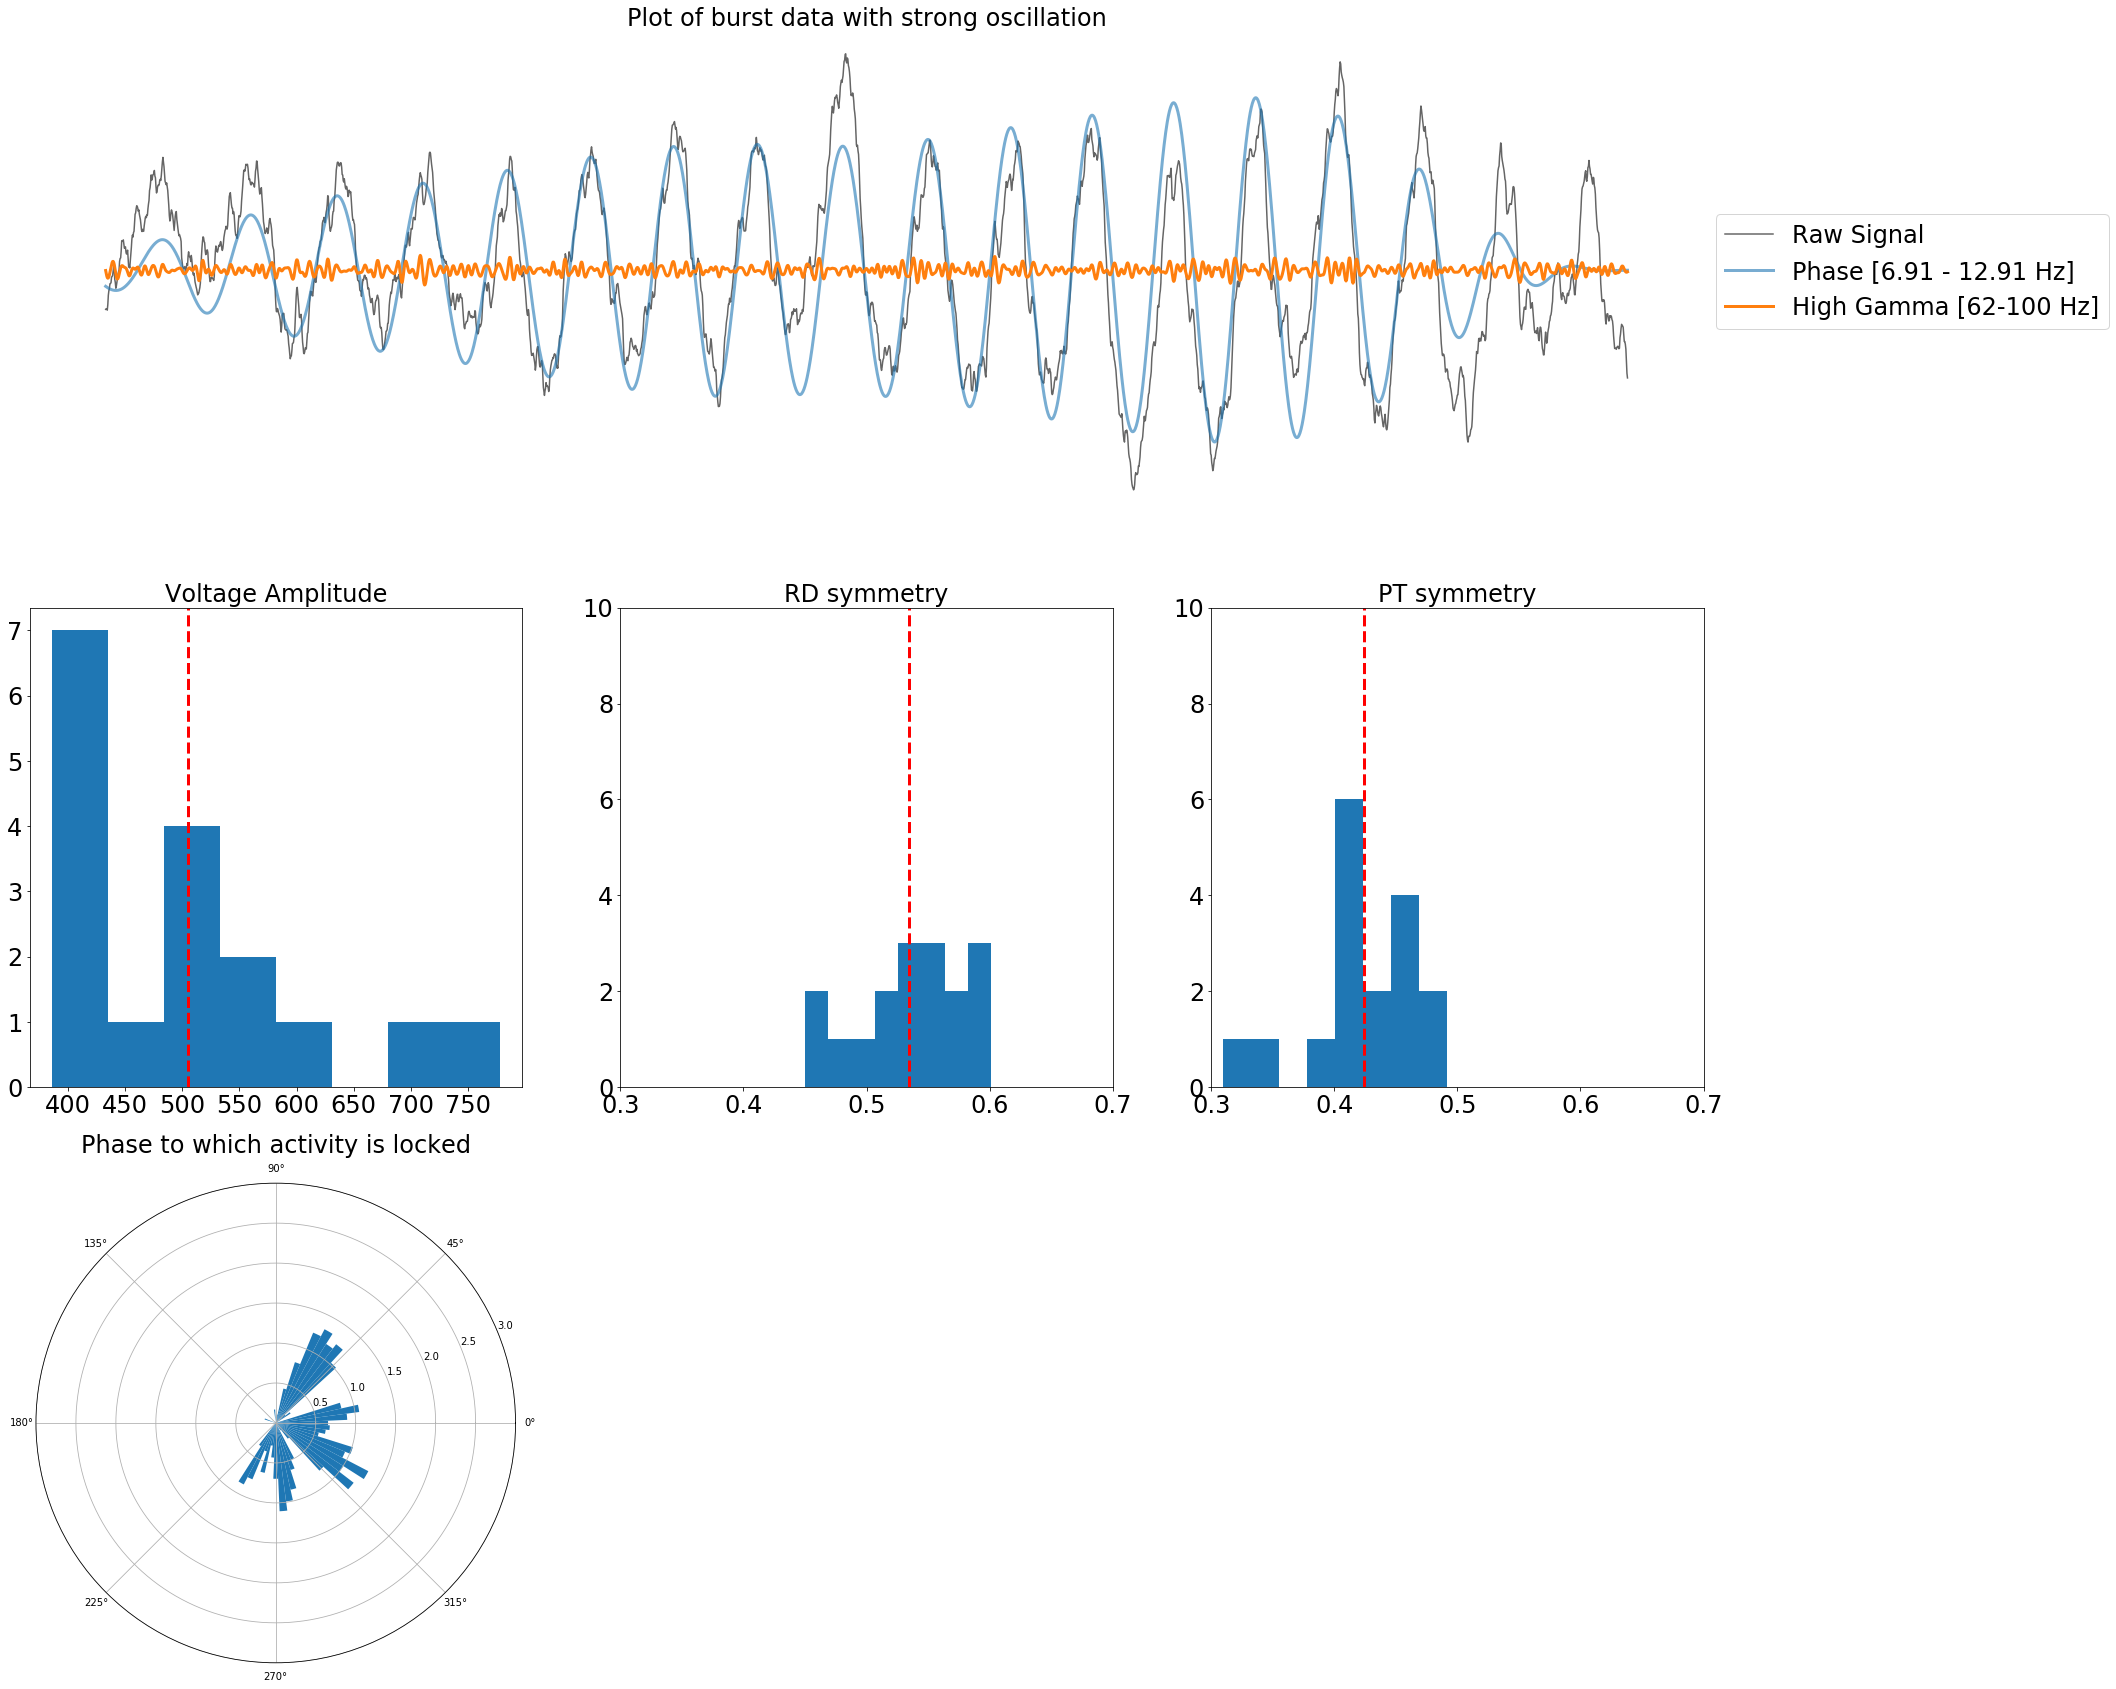

9.733568125336847
2.0000000000000004
The Rho-value of PAC is:      0.1767078085272468
The p-value of PAC is:        0.0


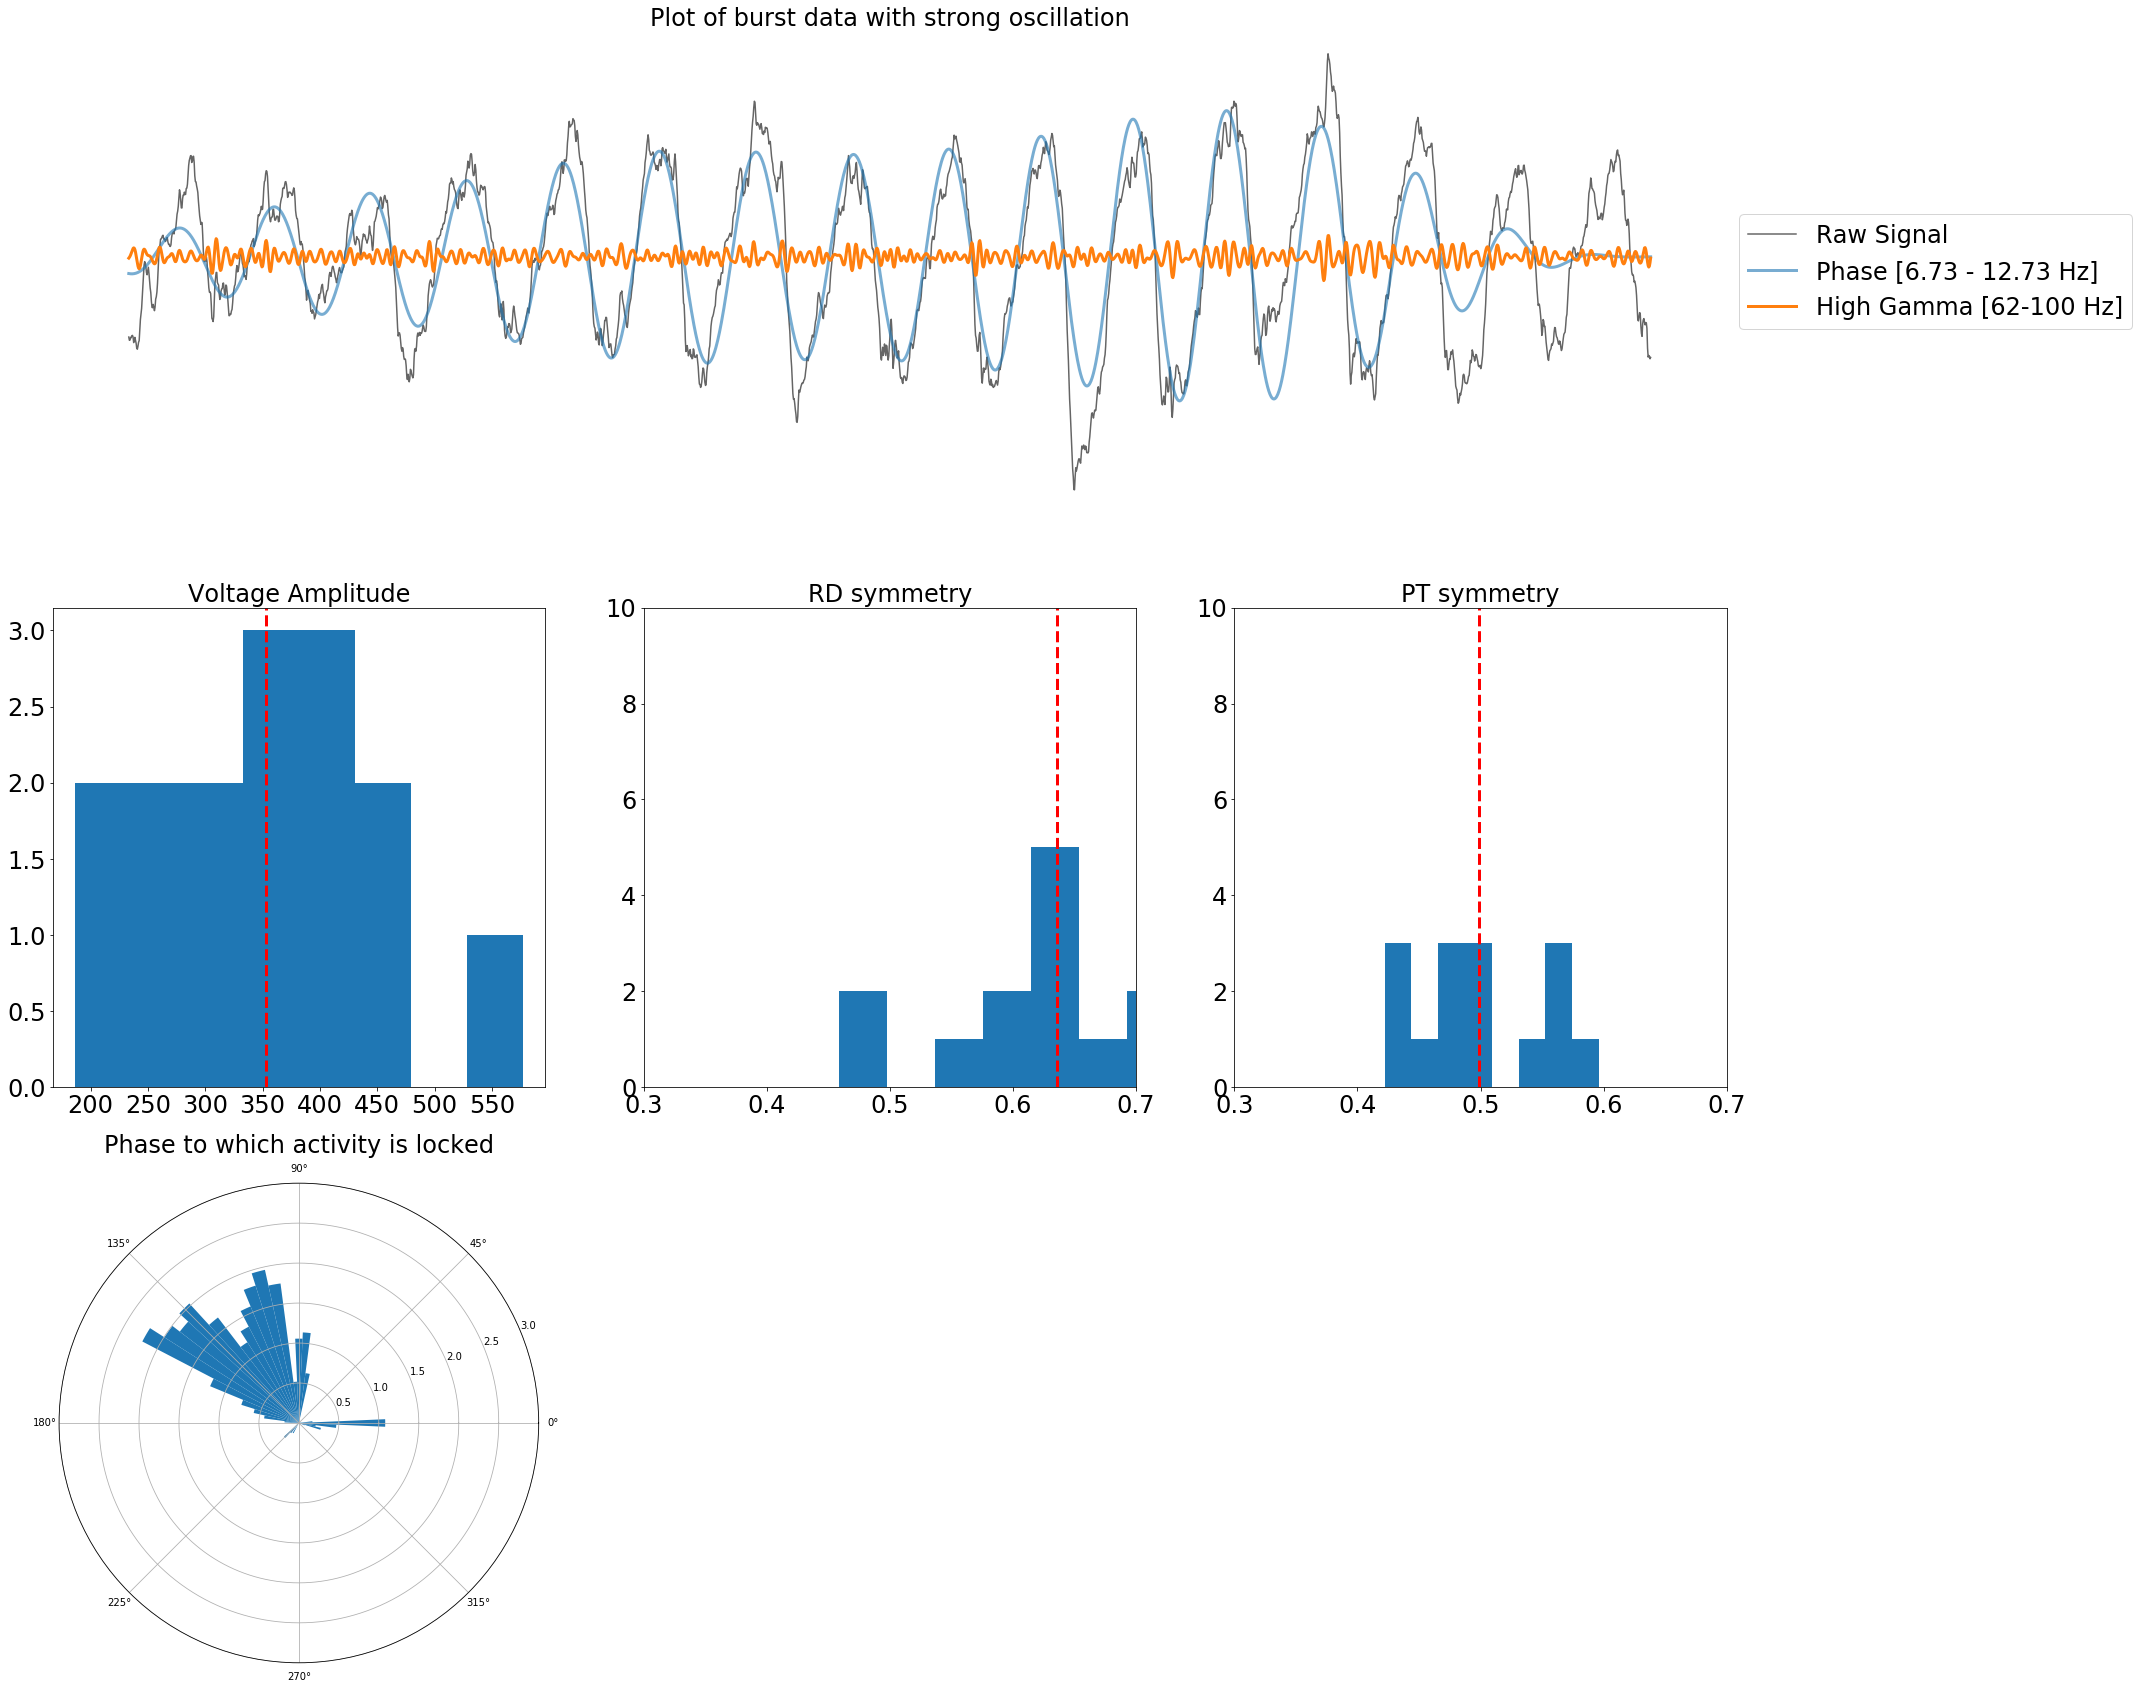

In [122]:
fs = 1500

# set range of the band 
amplitude_providing_band = [65, 150]

for ii in range(2750,2850):
    
    if burst_list[ii] is not None:
        
        if burst_list[ii][2]:

            # define phase providing band
            CF = features_df['CF'][ii]
            BW = features_df['BW'][ii]

            # making the phase bands 2 bigger on each side works better,
            # so have to check whether FOOOF functions properly

            # phase_providing_band= [(CF - (BW/2)),  (CF + (BW/2))]
            phase_providing_band= [(CF - (BW/2))-1,  (CF + (BW/2))+1]
            # phase_providing_band = [1, 30]

            subj = features_df['subj'][ii]
            day = features_df['day'][ii]
            ch = features_df['ch'][ii]
            ep = features_df['ep'][ii]

            start_sample = burst_list[ii][0]
            end_sample = burst_list[ii][1]

            data = datastruct[subj][day][ch][ep][start_sample:end_sample]

            # use butter bandpass filter to extract this frequency range
            phase_data = pacf.butter_bandpass_filter(data, phase_providing_band[0], phase_providing_band[1], fs);
            phase_data_hilbert = hilbert(phase_data);
            phase_data_angle = np.angle(phase_data_hilbert);
            
            # use butter bandpass filter to extract this frequency range
            amp_data = pacf.butter_bandpass_filter(data, amplitude_providing_band[0], amplitude_providing_band[1], fs);
            amp_data_hilbert = hilbert(amp_data);
            amp_data_abs = abs(amp_data_hilbert);
            
            print(CF)
            print(BW)

            # plot signal
            # plt.figure(figsize=(30,30))
            fig = plt.figure(figsize=(30,30))
            gs = fig.add_gridspec(3, 3)
            
            # ax1: signal plot
            f_ax1 = fig.add_subplot(gs[0, :])
            plt.plot(data - np.mean(data),label= 'Raw Signal', color='black', alpha=.6)
            plt.plot(phase_data,
                     label= 'Phase [{0:.2f} - {1:.2f} Hz]'.format(phase_providing_band[0]-1, phase_providing_band[1]+1),
                     linewidth=3, alpha=.6)
            plt.plot(amp_data,label= 'High Gamma [62-100 Hz]',
                     linewidth=3)
            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=24)
            plt.title('Plot of burst data with strong oscillation', size=24)
            plt.axis('off')
            
            # ax2: Amplitude distribution
            f_ax2 = fig.add_subplot(gs[1,0])
            plt.hist(burst_list[ii][2], bins=8)
            plt.axvline(np.mean(burst_list[ii][2]), color='red', linestyle='dashed', linewidth=3)
            plt.title('Voltage Amplitude', size=24)
            plt.xticks(fontsize=24)
            plt.yticks(fontsize=24)

           
            # ax3: RD Symmetry
            f_ax3 = fig.add_subplot(gs[1,1])
            plt.hist(burst_list[ii][3],bins=8)
            plt.axvline(np.mean(burst_list[ii][3]), color='red', linestyle='dashed', linewidth=3)
            plt.title('RD symmetry', size=24)
            plt.xticks(np.arange(0.3, 0.8, step=0.1), fontsize=24)
            plt.yticks(fontsize=24)
            plt.xlim((0.3,0.7))
            plt.ylim(0,10)
            
            
            # ax4: PT Symmetry
            f_ax4 = fig.add_subplot(gs[1,2])
            plt.hist(burst_list[ii][4], bins=8)
            plt.axvline(np.mean(burst_list[ii][4]), color='red', linestyle='dashed', linewidth=3)
            plt.title('PT symmetry', size=24)
            plt.xticks(np.arange(0.3, 0.8, step=0.1), fontsize=24)
            plt.yticks(fontsize=24)
            plt.xlim((0.3,0.7))
            plt.ylim(0,10)
            #plt.show()
            
            
            # preprocessing circle plot
            bin_size = 5; 
            bins = range(-180,180+bin_size,bin_size); 
            bins = np.dot(bins, 0.0174532925);

            amps = [];

            #filling phase bins with amplitudes
            for x in range(len(bins)-1):
                # find the lower bound of the bin
                amps_above_lo_bound = np.where(phase_data_angle >= bins[x])[0];
                # find the higher bound of the bin
                amps_below_hi_bound = np.where(phase_data_angle < bins[x+1])[0];
                amps_below_hi_bound = set(amps_below_hi_bound);
                # select all samples that are within the range
                amp_inds_in_this_bin = [amp_val for amp_val in amps_above_lo_bound if amp_val in amps_below_hi_bound]
                # find corresponding amplitudes for these samples
                amps_in_this_bin = amp_data_abs[amp_inds_in_this_bin];
                # calculate mean
                amps.append(np.mean(amps_in_this_bin));

            bins = bins[:len(bins)-1];

            #normalizing to make the effect more clear
            amps = (amps-np.mean(amps))/np.std(amps);

            #plotting figure;
            # ax5: Circle correlation
            f_ax3 = fig.add_subplot(gs[2,0], projection='polar')
            plt.bar(bins, amps, width=bins[1]-bins[0], bottom=0.0)
            plt.ylim([0,3])
            plt.title('Phase to which activity is locked', size=24);
            

            #calculate circle correlation
            rho, pval, r_2, standard_error = circCorr(phase_data_angle, amp_data_abs)

            print('The Rho-value of PAC is:     ', rho)
            print('The p-value of PAC is:       ', pval)
            
            
            # include: 
            # second row of signal: raw, phase and amplitude
            
            # PSD
            
            # stats
            
            
            
            plt.show()


In [ ]:
if burst_list[ii][2]:
    print('hi')